##Библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install catboost

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor

from catboost import CatBoostRegressor, Pool
import lightgbm as lgb

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import mean_squared_error

In [ ]:
def RMSE(y_true, y_pred):
  return mean_squared_error(y_true, y_pred, squared=False)

## Homework

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX' -O data.csv

--2021-12-10 15:08:55--  https://docs.google.com/uc?export=download&id=1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX
Resolving docs.google.com (docs.google.com)... 142.251.6.100, 142.251.6.138, 142.251.6.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.6.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fmrfshvb1oq15c08dcbm42v9n3memkde/1639148925000/03856158561714992485/*/1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX?e=download [following]
--2021-12-10 15:08:57--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fmrfshvb1oq15c08dcbm42v9n3memkde/1639148925000/03856158561714992485/*/1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX?e=download
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 142.250.1.132, 2607:f8b0:4001:c24::84
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.g

В этой домашней работе вы будете предсказывать стоимость домов по их характеристикам.

Метрика качества: `RMSE`

Оценивание:
* Baseline - 2 балла
* Feature Engineering - 2 балла
* Model Selection - 3 балла
* Ensemble v.1 - 3 балла
* (*) Ensemble v.2 - дополнительно, 2 балла

### Описание датасета

Короткое описание данных:
```
price: sale price (this is the target variable)
id: transaction id
timestamp: date of transaction
full_sq: total area in square meters, including loggias, balconies and other non-residential areas
life_sq: living area in square meters, excluding loggias, balconies and other non-residential areas
floor: for apartments, floor of the building
max_floor: number of floors in the building
material: wall material
build_year: year built
num_room: number of living rooms
kitch_sq: kitchen area
state: apartment condition
product_type: owner-occupier purchase or investment
sub_area: name of the district

The dataset also includes a collection of features about each property's surrounding neighbourhood, and some features that are constant across each sub area (known as a Raion). Most of the feature names are self explanatory, with the following notes. See below for a complete list.

full_all: subarea population
male_f, female_f: subarea population by gender
young_*: population younger than working age
work_*: working-age population
ekder_*: retirement-age population
n_m_{all|male|female}: population between n and m years old
build_count_*: buildings in the subarea by construction type or year
x_count_500: the number of x within 500m of the property
x_part_500: the share of x within 500m of the property
_sqm_: square meters
cafe_count_d_price_p: number of cafes within d meters of the property that have an average bill under p RUB
trc_: shopping malls
prom_: industrial zones
green_: green zones
metro_: subway
_avto_: distances by car
mkad_: Moscow Circle Auto Road
ttk_: Third Transport Ring
sadovoe_: Garden Ring
bulvar_ring_: Boulevard Ring
kremlin_: City center
zd_vokzaly_: Train station
oil_chemistry_: Dirty industry
ts_: Power plant
```

## Setup

In [ ]:
df = pd.read_csv("data.csv", parse_dates=["timestamp"])
df.shape

(20000, 292)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 292 entries, id to price
dtypes: datetime64[ns](1), float64(119), int64(157), object(15)
memory usage: 44.6+ MB


In [ ]:
drop_columns = [
    'id',           # May leak information
    'timestamp',    # May leak information
]
cat_columns = [
    'product_type',              #
    'material',                  # Material of the wall
    'state',                     # Satisfaction level
    'sub_area',                  # District name
    'culture_objects_top_25',    #
    'thermal_power_plant_raion', #
    'incineration_raion',        #
    'oil_chemistry_raion',       #
    'radiation_raion',           #
    'railroad_terminal_raion',   #
    'big_market_raion',          #
    'nuclear_reactor_raion',     #
    'detention_facility_raion',  #
    'ID_metro',                  #
    'ID_railroad_station_walk',  #
    'ID_railroad_station_avto',  #
    'water_1line',               #
    'ID_big_road1',              #
    'big_road1_1line',           #
    'ID_big_road2',              #
    'railroad_1line',            #
    'ID_railroad_terminal',      #
    'ID_bus_terminal',           #
    'ecology',                   #
]
num_columns = list(set(df.columns).difference(set(cat_columns + drop_columns)))

In [ ]:
df.isna().mean().sum()

8.48035

Для числовых колонок заполняем пропуски средним значением

Для категориальных - самым популярным

In [ ]:
for column in num_columns:
  df[column].fillna(df[column].mean(), inplace=True)
for column in cat_columns:
  filled = df[column].value_counts().argmax()
  df[column].fillna(filled, inplace=True)

df2 = df.copy()
df.isna().mean().sum(), df2.isna().mean().sum()

(0.0, 0.0)

In [ ]:
for column in cat_columns:
  le = LabelEncoder()
  df[column] = le.fit_transform(df[column])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 292 entries, id to price
dtypes: datetime64[ns](1), float64(116), int64(175)
memory usage: 44.6 MB


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 292 entries, id to price
dtypes: datetime64[ns](1), float64(119), int64(157), object(15)
memory usage: 44.6+ MB


In [ ]:
df_copy = df.copy()
df_copy.drop(columns=drop_columns, axis=1, inplace=True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 290 entries, full_sq to price
dtypes: float64(116), int64(174)
memory usage: 44.3 MB


In [ ]:
df_copy.isna().mean().sum()

0.0

Разделите имеющиеся у вас данные на обучающую и тестовую выборки. В качестве обучающей выборки возьмите первые 80% данных, последние 20% - тестовая выборка.

Разделение ниже

## Baseline (2 балла)

В качестве Baseline обучите `DecisionTreeRegressor` из `sklearn`.

In [ ]:
def get_tree_rmse(df):
  y = df["price"]
  X = df.drop(columns=["price"], axis=1)

  sdc = StandardScaler()
  X_sdc = sdc.fit_transform(X)

  X_train, X_test, y_train, y_test = train_test_split(X_sdc, y, test_size=0.2, random_state=42)

  grid = {"max_depth": np.arange(3, 20)}
  tree = GridSearchCV(DecisionTreeRegressor(random_state=42), grid, cv=5, verbose=0)
  tree.fit(X_train, y_train)
  tree_pred = tree.predict(X_test)
  
  return RMSE(y_test, tree_pred)

Попробуем не переводить категориальные в числовые. Удалим их. Возможно они создают помеху

In [ ]:
df_copy2 = df.copy()
df_copy2.drop(columns=drop_columns, axis=1, inplace=True)
df_copy2.drop(columns=cat_columns, axis=1, inplace=True)
df_copy2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 266 entries, full_sq to price
dtypes: float64(116), int64(150)
memory usage: 40.6 MB


Удалим категориальные признаки с ID-ами. Может быть они не важны

In [ ]:
df_copy3 = df.copy()
drop_columns2 = []
for col in cat_columns:
  if "ID" in col:
      drop_columns2.append(col)
print(drop_columns2)
df_copy3.drop(columns=drop_columns, axis=1, inplace=True)
df_copy3.drop(columns=drop_columns2, axis=1, inplace=True)
df_copy3.info()

['ID_metro', 'ID_railroad_station_walk', 'ID_railroad_station_avto', 'ID_big_road1', 'ID_big_road2', 'ID_railroad_terminal', 'ID_bus_terminal']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 283 entries, full_sq to price
dtypes: float64(116), int64(167)
memory usage: 43.2 MB


Проверьте качество на отложенной выборке.

In [ ]:
rmse1 = get_tree_rmse(df_copy)
rmse2 = get_tree_rmse(df_copy2)
rmse3 = get_tree_rmse(df_copy3)

In [ ]:
print(f"RMSE на полных данных = {round(rmse1)}")
print(f"RMSE на данных без категориальных признаков = {round(rmse2)}")
print(f"RMSE на данных без id = {round(rmse3)}")

RMSE на полных данных = 3261307
RMSE на данных без категориальных признаков = 3197752
RMSE на данных без id = 3110006


## Feature Engineering (2 балла)

Часто улучшить модель можно с помощью аккуратного Feature Engineering.

Добавим в модель дополнительные признаки:
* "Как часто в этот год и этот месяц появлились объявления"
* "Как часто в этот год и эту неделю появлялись объявления"

In [ ]:
month_year = (df.timestamp.dt.month + df.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df["month_year_cnt"] = month_year.map(month_year_cnt_map)
df2["month_year_cnt"] = month_year.map(month_year_cnt_map)

week_year = (df.timestamp.dt.weekofyear + df.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df["week_year_cnt"] = week_year.map(week_year_cnt_map)
df2["week_year_cnt"] = week_year.map(week_year_cnt_map)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


Добавьте следюущие дополнительные признаки:
* Месяц (из колонки `timestamp`)
* День недели (из колонки `timestamp`)
* Отношение "этаж / максимальный этаж в здании" (колонки `floor` и `max_floor`)
* Отношение "площадь кухни / площадь квартиры" (колонки `kitchen_sq` и `full_sq`)

По желанию можно добавить и другие признаки.

In [ ]:
df["non_zero_max_floor"] = df["max_floor"].apply(lambda x: x if x != 0 else 1)
df["non_zero_full_sq"] = df["full_sq"].apply(lambda x: x if x != 0 else 1)
(df["non_zero_max_floor"] == 0).sum(), (df["non_zero_full_sq"] == 0).sum()

(0, 0)

In [ ]:
df["month"] = df["timestamp"].apply(lambda x: int(str(x)[5:7]))
df["year"] = df["timestamp"].apply(lambda x: int(str(x)[0:4]))
df["weekday"] = df["timestamp"].apply(lambda x: x.to_pydatetime().weekday())
df["floors_attitude"] = df["floor"] / df["non_zero_max_floor"]
df["kitchen_attitude"] = df["kitch_sq"] / df["non_zero_full_sq"]

df2["month"] = df["timestamp"].apply(lambda x: int(str(x)[5:7]))
df2["year"] =  df["timestamp"].apply(lambda x: int(str(x)[0:4]))
df2["weekday"] = df["timestamp"].apply(lambda x: x.to_pydatetime().weekday())
df2["floors_attitude"] = df["floor"] / df["non_zero_max_floor"]
df2["kitchen_attitude"] = df["kitch_sq"] / df["non_zero_full_sq"]

Разделите выборку на обучающую и тестовую еще раз (потому что дополнительные признаки созданы для исходной выборки).

In [ ]:
new_int_columns = ("month_year_cnt", "week_year_cnt", "month", "weekday", "floors_attitude", "kitchen_attitude")
num_columns.extend(new_int_columns)

In [ ]:
df_copy4 = df.copy()
drop_columns2 = []
for col in cat_columns:
  if "ID" in col:
      drop_columns2.append(col)

df_copy4.drop(columns=drop_columns, axis=1, inplace=True)
df_copy4.drop(columns=drop_columns2, axis=1, inplace=True)
df_copy4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 292 entries, full_sq to kitchen_attitude
dtypes: float64(119), int64(173)
memory usage: 44.6 MB


In [ ]:
y = df_copy4["price"]
X = df_copy4.drop(columns=["price"], axis=1)

sdc = StandardScaler()
X_sdc = sdc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_sdc, y, test_size=0.2, random_state=42)

## Model Selection (3 балла)

Посмотрите, какого качества можно добиться если использовать разные модели:
* `DecisionTreeRegressor` из `sklearn`
* `RandomForestRegressor` из `sklearn`
* `CatBoostRegressor`

Также вы можете попробовать линейные модели, другие бустинги (`LigthGBM` и `XGBoost`).

Почти все библиотеки поддерживают удобный способ подбора гиперпараметров: посмотрите как это делать в [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) или в [catboost](https://catboost.ai/docs/concepts/python-reference_catboostregressor_grid_search.html).

Проверяйте качество каждой модели на тестовой выборке и выберите наилучшую.

###CatBoost

In [ ]:
grid = {'iterations': [100, 150, 200, 500, 1000],
        'learning_rate': [0.03, 0.07, 0.1]
        }

catboost = CatBoostRegressor(random_state=42)
catboost.grid_search(grid, X_train, y_train)
catboost_pred = catboost.predict(X_test)

Выходные данные были обрезаны до нескольких последних строк (5000).
26:	learn: 3111694.1810683	test: 3062201.8762775	best: 3062201.8762775 (26)	total: 1.69s	remaining: 1m
27:	learn: 3068416.1905863	test: 3026418.4455373	best: 3026418.4455373 (27)	total: 1.75s	remaining: 1m
28:	learn: 3025535.5866808	test: 2989065.2688914	best: 2989065.2688914 (28)	total: 1.81s	remaining: 1m
29:	learn: 2985135.5537632	test: 2960743.7708066	best: 2960743.7708066 (29)	total: 1.87s	remaining: 1m
30:	learn: 2951776.2968155	test: 2938418.4264260	best: 2938418.4264260 (30)	total: 1.93s	remaining: 1m
31:	learn: 2920328.3267940	test: 2912144.1464297	best: 2912144.1464297 (31)	total: 2s	remaining: 1m
32:	learn: 2885073.0737047	test: 2889041.8496185	best: 2889041.8496185 (32)	total: 2.06s	remaining: 1m
33:	learn: 2857093.4237198	test: 2867944.6458360	best: 2867944.6458360 (33)	total: 2.12s	remaining: 1m
34:	learn: 2834087.8815523	test: 2850798.5505988	best: 2850798.5505988 (34)	total: 2.17s	remaining: 60s
35:	lea

In [ ]:
catboost.get_params()

{'iterations': 1000,
 'learning_rate': 0.1,
 'loss_function': 'RMSE',
 'random_state': 42}

In [ ]:
catboost_rmse = round(RMSE(y_test, catboost_pred))
catboost_rmse

2492050

###LightGBM

In [ ]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [ ]:
gbm = lgb.train(params, lgb_train,
            num_boost_round=500,
            valid_sets=[lgb_train, lgb_eval],
            early_stopping_rounds=10)
gbm_predict = gbm.predict(X_test)

[1]	training's l2: 2.07808e+13	training's l1: 2.79937e+06	valid_1's l2: 1.87158e+13	valid_1's l1: 2.76929e+06
Training until validation scores don't improve for 10 rounds.
[2]	training's l2: 1.95307e+13	training's l1: 2.71621e+06	valid_1's l2: 1.76442e+13	valid_1's l1: 2.68981e+06
[3]	training's l2: 1.83886e+13	training's l1: 2.63928e+06	valid_1's l2: 1.6624e+13	valid_1's l1: 2.61513e+06
[4]	training's l2: 1.7345e+13	training's l1: 2.56604e+06	valid_1's l2: 1.57694e+13	valid_1's l1: 2.54588e+06
[5]	training's l2: 1.63952e+13	training's l1: 2.49654e+06	valid_1's l2: 1.49656e+13	valid_1's l1: 2.47823e+06
[6]	training's l2: 1.55491e+13	training's l1: 2.4305e+06	valid_1's l2: 1.43081e+13	valid_1's l1: 2.41717e+06
[7]	training's l2: 1.47727e+13	training's l1: 2.36841e+06	valid_1's l2: 1.36987e+13	valid_1's l1: 2.36022e+06
[8]	training's l2: 1.40492e+13	training's l1: 2.31008e+06	valid_1's l2: 1.31097e+13	valid_1's l1: 2.30697e+06
[9]	training's l2: 1.33927e+13	training's l1: 2.25506e+06	val

In [ ]:
gbm_rmse = round(RMSE(y_test, gbm_predict))
gbm_rmse

2515880

###Случайный лес

In [ ]:
random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train, y_train)
random_forest_pred = random_forest.predict(X_test)

In [ ]:
random_forest_rmse = round(RMSE(y_test, random_forest_pred))
random_forest_rmse

2616084

###Дерево решений


In [ ]:
tree_rmse = round(get_tree_rmse(df_copy4))
tree_rmse

3198426

###Итог

In [ ]:
print(f"CatBoosting = {catboost_rmse}")
print(f"LightGBM = {gbm_rmse}")
print(f"Случайный лес = {random_forest_rmse}")
print(f"Дерево решений = {tree_rmse}")

CatBoosting = 2492050
LightGBM = 2515880
Случайный лес = 2616084
Дерево решений = 3198426


## Ensemble v.1 (3 балла)

Ансамбли иногда оказываются лучше чем одна большая модель.

В колонке `product_type` содержится информация о том, каким является объявление: `Investment` (продажа квартиры как инвестиции) или `OwnerOccupier` (продажа квартиры для жилья). Логично предположить, что если сделать по модели на каждый из этих типов, то качество будет выше.

Обучите свои лучшие модели на отдельно на `Investment` и `OwnerOccupier` (т.е. у вас будет `model_invest`, обученная на `(invest_train_X, invest_train_Y)` и `model_owner`, обученная на `(owner_train_X, owner_train_Y)`) и проверьте качество на отложенной выборке (т.е. на исходном `test_split`).

###Подготовка данных

In [ ]:
df2["product_type"].value_counts()

Investment       12840
OwnerOccupier     7160
Name: product_type, dtype: int64

In [ ]:
df["product_type"].value_counts()

0    12840
1     7160
Name: product_type, dtype: int64

In [ ]:
df_investment = df[df["product_type"] == 0]

y0 = df_investment["price"]
df_investment.drop(columns=drop_columns, axis=1, inplace=True)
X0 = df_investment.drop(columns=["price"], axis=1)

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=42)
X0_train.shape, X0_test.shape, y0_train.shape, y0_test.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


((10272, 298), (2568, 298), (10272,), (2568,))

In [ ]:
df_owner_occupier = df[df["product_type"] == 1]

y1 = df_owner_occupier["price"]
df_owner_occupier.drop(columns=drop_columns, axis=1, inplace=True)
X1 = df_owner_occupier.drop(columns=["price"], axis=1)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

###Обучим CatBoost, как лучшую модель

In [ ]:
catboost_inv = CatBoostRegressor(iterations=1000,
                                 learning_rate=0.07,
                                 loss_function="RMSE",
                                 random_state=42)
catboost_inv.fit(X0_train, y0_train, verbose=False)
catboost_inv_pred = catboost_inv.predict(X0_test)

In [ ]:
catboost_owner = CatBoostRegressor(iterations=1000,
                                   learning_rate=0.07,
                                   loss_function="RMSE",
                                   random_state=42)
catboost_owner.fit(X1_train, y1_train, verbose=False)
catboost_owner_pred = catboost_owner.predict(X1_test)

In [ ]:
y_test = np.concatenate([y0_test, y1_test])
catboost_pred = np.concatenate([catboost_inv_pred, catboost_owner_pred])

ansamble_rmse = round(RMSE(y_test, catboost_pred))
ansamble_rmse

2474056

## (*) Ensemble v.2 (дополнительно, 2 балла)

Попробуйте сделать для `Investment` более сложную модель: обучите `CatBoostRegressor` и `HuberRegressor` из `sklearn`, а затем сложите их предсказания с весами `w_1` и `w_2` (выберите веса сами; сумма весов равняется 1).

In [ ]:
grid = {"alpha": [0.00001, 0.001, 0.01, 0.1, 1.0],
        "epsilon": [1.15, 1.35, 1.5],
        "max_iter": [100, 500, 1000]
        }

huber = GridSearchCV(HuberRegressor(), grid, cv=2, verbose=0)
huber.fit(X0_train, y0_train)
huber_pred = huber.predict(X0_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_ite

In [ ]:
huber.best_estimator_

HuberRegressor(alpha=1.0, epsilon=1.5, max_iter=1000)

In [ ]:
errors = []
weights = np.arange(0.1, 1, 0.1)
for w in weights:
  pred = w*catboost_inv_pred + (1-w)*huber_pred
  errors.append(RMSE(y0_test, pred))
errors = np.array(errors)
w = weights[errors.argmin()]
print(f"{w} * CatBoostPrediction + {1-w} * HuberPrediction = {errors.min()}")

0.9 * CatBoostPrediction + 0.09999999999999998 * HuberPrediction = 3003889.9742177133


In [ ]:
ansamble_inv_pred = w*catboost_inv_pred + (1-w)*huber_pred
ansamble_pred = np.concatenate([ansamble_inv_pred, catboost_owner_pred])

ansamble_rmse2 = round(RMSE(y_test, ansamble_pred))
ansamble_rmse2

2483177

##Итог

In [ ]:
models = np.array(["Ансамбль из CatBoost", "Ансамбль из CatBoost + Huber", 
                   "Случайный лес", "Дерево решений", "CatBoost", "LightGBM"])
rmses = np.array([ansamble_rmse, ansamble_rmse2, random_forest_rmse, tree_rmse,
                  catboost_rmse, gbm_rmse])

index_sort = rmses.argsort()
rmses.sort()
models = models[index_sort]

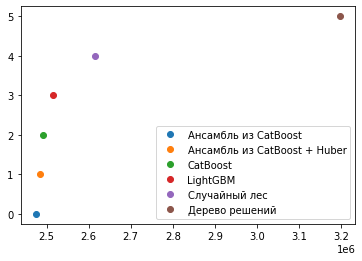

In [ ]:
for i, rmse in np.ndenumerate(rmses):
  plt.plot(rmse, i, 'o', label=i)
plt.legend(models)
plt.show()